In [1]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import cv2
import os

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torch.nn.parallel

from effdet import create_model, create_evaluator, create_dataset, create_loader
from effdet.data import resolve_input_config
from timm.utils import AverageMeter, setup_default_logging
from timm.models.layers import set_layer_config


from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

import wandb

In [2]:
import torch
import os
from datetime import datetime
import time
import random

from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [3]:
class CustomDataset(Dataset):
    '''
      data_dir: data가 존재하는 폴더 경로
      transforms: data transform (resize, crop, Totensor, etc,,,)
    '''

    def __init__(self, annotation, data_dir, transforms=None):
        super().__init__()
        self.data_dir = data_dir
        # coco annotation 불러오기 (coco API)
        self.coco = COCO(annotation)
        self.predictions = {
            "images": self.coco.dataset["images"].copy(),
            "categories": self.coco.dataset["categories"].copy(),
            "annotations": None
        }
        self.transforms = transforms

    def __getitem__(self, index: int):
        
        image_id = self.coco.getImgIds(imgIds=index)

        image_info = self.coco.loadImgs(image_id)[0]
        
        image = cv2.imread(os.path.join(self.data_dir, image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        anns = self.coco.loadAnns(ann_ids)

        boxes = np.array([x['bbox'] for x in anns])

        # boxex (x_min, y_min, x_max, y_max)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        labels = np.array([x['category_id'] for x in anns])
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        areas = np.array([x['area'] for x in anns])
        areas = torch.as_tensor(areas, dtype=torch.float32)
                                
        is_crowds = np.array([x['iscrowd'] for x in anns])
        is_crowds = torch.as_tensor(is_crowds, dtype=torch.int64)
                                
        segmentation = np.array([x['segmentation'] for x in anns], dtype=object)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([index]), 'area': areas,
                  'iscrowd': is_crowds}

        # transform
        if self.transforms:
            sample = self.transforms(**{
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            })
            if len(sample['bboxes']) > 0:
                image = sample['image']
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)
                target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]
                target['labels'] = torch.tensor(sample['labels'])
                

        return image, target, image_id
    
    def __len__(self) -> int:
        return len(self.coco.getImgIds())

In [4]:
def get_train_transform():
    return A.Compose([
        A.Resize(512,512),
        A.Flip(p=0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields':['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields':['labels']})

loading annotations into memory...
Done (t=3.47s)
creating index...
index created!
loading annotations into memory...
Done (t=0.88s)
creating index...
index created!


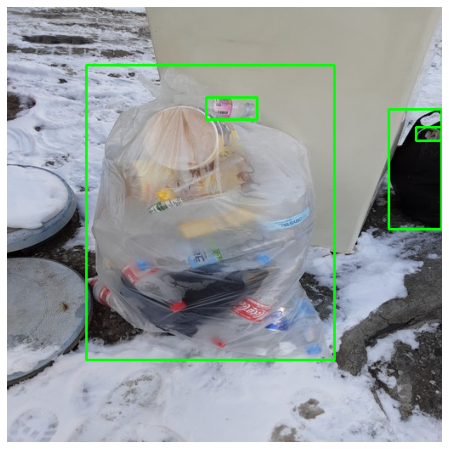

In [10]:
annotation = '/opt/ml/input/data/train.json'
data_dir = '/opt/ml/input/data/'
train_dataset = CustomDataset(annotation, data_dir, get_train_transform())
val_annotation = '/opt/ml/input/data/val.json'
val_dataset = CustomDataset(val_annotation, data_dir, get_valid_transform())

image, target, image_id = train_dataset[200]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image)

In [6]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self,value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

def collate_fn(batch):
    return tuple(zip(*batch))

In [7]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.pth')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.pth')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.pth'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()

                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                target = { 'bbox': boxes, 'cls': labels, 'img_scale': None, 'img_size': None }

                # loss, _, _ = self.model(images, boxes, labels)
#                 loss, cls_loss, box_loss = self.model(images, target).values()
                outputs = self.model(images,target)
                loss = outputs['loss']
                summary_loss.update(loss.detach().item(), batch_size)
                # for out in output:
                #     outputs.append({'boxes': out['boxes'].tolist(), 'scores': out['scores'].tolist(), 'labels': out['labels'].tolist()})


        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            

            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            target = { 'bbox': boxes, 'cls': labels, 'img_scale': None, 'img_size': None }

            self.optimizer.zero_grad()

            # targets
            outputs = self.model(images, target)
            loss = outputs['loss']

            loss.backward()
            # boxes = [target['boxes'].to(self.device).float() for target in targets]
            # labels = [target['labels'].to(self.device).float() for target in targets]

            # self.optimizer.zero_grad()
            
            # loss, _, _ = self.model(images, boxes, labels)
            
            # loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')


In [8]:
class TrainGlobalConfig:
    num_workers = 4
    batch_size = 4
    n_epochs = 40 # n_epochs = 40
    lr=3e-5
    weight_decay=1e-6
    
    folder = './work_dirs/effdet4'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------


In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(val_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)


In [11]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():

    config = get_efficientdet_config('efficientdet_d3')

    config.image_size = [512,512]
    config.norm_kwargs=dict(eps=.001, momentum=.01)
    config.soft_nms = True

    net = EfficientDet(config, pretrained_backbone=True)
    # checkpoint = torch.load('./work_dirs/effdet')
    # net.load_state_dict(checkpoint)

    net.reset_head(num_classes=11)
    net.class_net = HeadNet(config, num_outputs=config.num_classes)

    return DetBenchTrain(net, config)

net = get_net()

In [ ]:
wandb.init(project="effdet", name='efficientdet_d3_softnms',
                entity='boostcamp_njys')
wandb.watch(net)
run_training()

wandb: Currently logged in as: hwan1753 (use `wandb login --relogin` to force relogin)


Fitter prepared. Device is cuda:0

2021-05-15T17:58:37.553754
LR: 3e-05
[RESULT]: Train. Epoch: 0, summary_loss: 566.80517, time: 338.07148
[RESULT]: Val. Epoch: 0, summary_loss: 451.74306, time: 2671.18874

2021-05-15T18:48:47.772126
LR: 3e-05
[RESULT]: Train. Epoch: 1, summary_loss: 209.42911, time: 337.77544
[RESULT]: Val. Epoch: 1, summary_loss: 143.63947, time: 2623.21716

2021-05-15T19:38:10.496229
LR: 3e-05
[RESULT]: Train. Epoch: 2, summary_loss: 66.38460, time: 342.17420
[RESULT]: Val. Epoch: 2, summary_loss: 53.08882, time: 2665.68672

2021-05-15T20:28:19.761304
LR: 3e-05
[RESULT]: Train. Epoch: 3, summary_loss: 27.06076, time: 341.84541
[RESULT]: Val. Epoch: 3, summary_loss: 23.73861, time: 2620.06311

2021-05-15T21:17:42.971020
LR: 3e-05
[RESULT]: Train. Epoch: 4, summary_loss: 12.60366, time: 340.44231
[RESULT]: Val. Epoch: 4, summary_loss: 12.67859, time: 2377.57150

2021-05-15T22:03:02.311828
LR: 3e-05
[RESULT]: Train. Epoch: 5, summary_loss: 7.05036, time: 339.01240
[RE